In [ ]:
import os
import json
from typing import Optional
from types import NoneType

from dotenv import load_dotenv
from openai import OpenAI
import gradio as gr

from sigmaepsilon.math.function import Function, Relation
from sigmaepsilon.math.optimize import LinearProgrammingProblem as LPP
import sympy as sy

In [ ]:
# Initialization

load_dotenv(override=True)

openai_api_key = os.getenv('OPENAI_API_KEY')
if openai_api_key:
    print(f"OpenAI API Key exists and begins {openai_api_key[:8]}")
else:
    print("OpenAI API Key not set")
    
MODEL = "gpt-4.1-mini"
openai = OpenAI()

# As an alternative, if you'd like to use Ollama instead of OpenAI
# Check that Ollama is running for you locally (see week1/day2 exercise) then uncomment these next 2 lines
# MODEL = "llama3.2"
# openai = OpenAI(base_url='http://localhost:11434/v1', api_key='ollama')

In [ ]:
system_message = """
You are a helpful assistant who solves linear programming problems.
You will receive the business definition of a linear programming problem.
Your task is to formulate the mathematical model, including the objective function and constraints.
Then, you will solve the linear programming problem using the provided optimization tool.
Provide the optimal solution and a brief explanation of the results.

Rules:
    - Always be accurate. If you don't know the answer, say so.
    - Always formulate the mathematical optimization problem as a minimization problem.
    - Use the optimization tool to solve the linear programming problem.
    - Recognize from the context if variables should be continuous or integer valued and provide this information to the optimization tool.
"""

In [58]:
def solve_linear_programming_problem(
        objective: str, 
        constrains: list[str], 
        variables: list[str], 
        bounds: Optional[list[tuple[float | NoneType, float | NoneType]]] = None,
        integrality: Optional[list[int]] = None
    ):
    """Solve a linear programming problem given an objective function, constraints, variables, bounds, and integrality conditions."""
    print("Solving LPP with:")
    print(f"Objective: {objective}")
    print(f"Constraints: {constrains}")
    print(f"Variables: {variables}")
    print(f"Bounds: {bounds}")
    print(f"Integrality: {integrality}")
    vars = sy.symbols(variables)
    obj = Function(objective, variables=vars)
    relations = [Relation(expression, variables=vars) for expression in constrains]
    lpp = LPP(obj, relations, variables=vars, bounds=bounds, integrality=integrality)
    solution = lpp.solve()
    return solution


# There's a particular dictionary structure that's required to describe our function:

lpp_function = {
    "name": "solve_linear_programming_problem",
    "description": "Solve a linear programming problem given an objective function, constraints, variables, bounds, and integrality conditions.",
    "parameters": {
        "type": "object",
        "properties": {
            "objective": {
                "type": "string",
                "description": "The objective function of the linear programming problem, expressed as a string.",
            },
            "constrains": {
                "type": "array",
                "items": {
                    "type": "string"
                },
                "description": "A list of constraints for the linear programming problem, each expressed as a string.",
            },
            "variables": {
                "type": "array",
                "items": {
                    "type": "string"
                },
                "description": "A list of variables used in the linear programming problem.",
            },
            "bounds": {
                "type": "array",
                "description": "A list of (lower, upper) bounds for each variable.",
                "items": {
                    "type": "array",
                    "items": {
                        "type": "number"   # or just "number" and you allow null in practice
                    },
                    "minItems": 2,
                    "maxItems": 2
                }
            },
            "integrality": {
                "type": "array",
                "items": {
                    "type": "integer"
                },
                "description": "A list indicating the integrality constraints for each variable. Each element is an integer specifying the integrality condition.",
            }
        },
        "required": ["objective", "constrains", "variables"],
        "additionalProperties": False
    }
}

tools = [{"type": "function", "function": lpp_function}]


solve_linear_programming_problem(
    objective="3*X1 + 5*X2",
    constrains=["2*X1 + 3*X2 <= 12", "X1 + X2 <= 5"],
    variables=["X1", "X2"],
    bounds=[(0, None), (0, None)]
)

Solving LPP with:
Objective: 3*X1 + 5*X2
Constraints: ['2*X1 + 3*X2 <= 12', 'X1 + X2 <= 5']
Variables: ['X1', 'X2']
Bounds: [(0, None), (0, None)]
Integrality: None


       message: Optimization terminated successfully. (HiGHS Status 7: Optimal)
       success: True
        status: 0
           fun: 0.0
             x: [ 0.000e+00  0.000e+00]
           nit: 0
         lower:  residual: [ 0.000e+00  0.000e+00]
                marginals: [ 3.000e+00  5.000e+00]
         upper:  residual: [       inf        inf]
                marginals: [ 0.000e+00  0.000e+00]
         eqlin:  residual: []
                marginals: []
       ineqlin:  residual: [ 1.200e+01  5.000e+00]
                marginals: [-0.000e+00 -0.000e+00]

In [ ]:
def handle_tool_calls(message):
    responses = []
    for tool_call in message.tool_calls:
        if tool_call.function.name == "solve_linear_programming_problem":
            arguments = json.loads(tool_call.function.arguments)
            objective = arguments.get('objective')
            constrains = arguments.get('constrains')
            variables = arguments.get('variables')
            bounds = arguments.get('bounds')
            integrality = arguments.get('integrality')
            solution = solve_linear_programming_problem(
                objective=objective,
                constrains=constrains,
                variables=variables,
                bounds=bounds,
                integrality=integrality
            )
            responses.append({
                "role": "tool",
                "content": str(solution),
                "tool_call_id": tool_call.id
            })
    return responses


def chat(message, history):
    history = [{"role":h["role"], "content":h["content"]} for h in history]
    messages = [{"role": "system", "content": system_message}] + history + [{"role": "user", "content": message}]
    response = openai.chat.completions.create(model=MODEL, messages=messages, tools=tools)

    while response.choices[0].finish_reason=="tool_calls":
        message = response.choices[0].message
        responses = handle_tool_calls(message)
        messages.append(message)
        messages.extend(responses)
        response = openai.chat.completions.create(model=MODEL, messages=messages, tools=tools)
    
    return response.choices[0].message.content

In [60]:
gr.ChatInterface(fn=chat).launch()

* Running on local URL:  http://127.0.0.1:7865
* To create a public link, set `share=True` in `launch()`.


Solving LPP with:
Objective: -30*x -50*y
Constraints: ['2*x + 3*y <= 600', '1*x + 2*y <= 400', 'y <= 150', 'x >= 100', 'x >= 0', 'y >= 0']
Variables: ['x', 'y']
Bounds: [[0, None], [0, None]]
Integrality: None


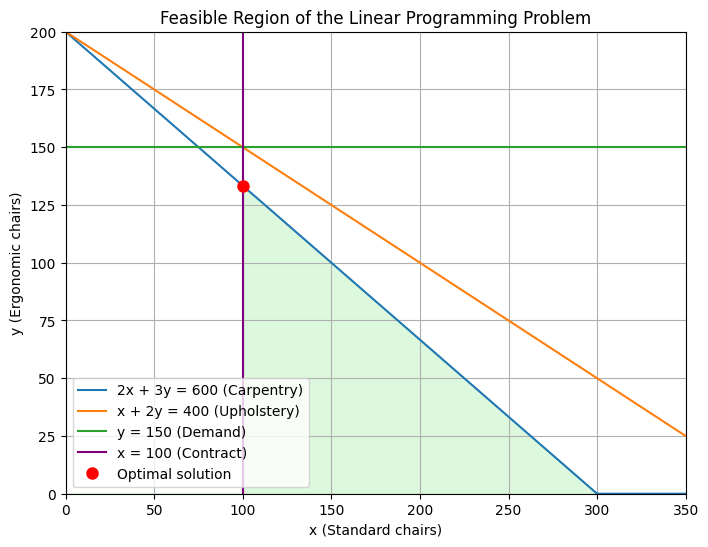

In [67]:
import numpy as np
import matplotlib.pyplot as plt

# Create a grid of x values
x = np.linspace(0, 400, 400)

# Constraint lines
y1 = (600 - 2*x) / 3          # Carpentry boundary
y2 = (400 - x) / 2            # Upholstery boundary
y3 = np.full_like(x, 150)     # Demand boundary

# Clip negative values
y1 = np.maximum(y1, 0)
y2 = np.maximum(y2, 0)

plt.figure(figsize=(8,6))

# Plot boundaries
plt.plot(x, y1, label="2x + 3y = 600 (Carpentry)")
plt.plot(x, y2, label="x + 2y = 400 (Upholstery)")
plt.plot(x, y3, label="y = 150 (Demand)")
plt.axvline(100, color="purple", label="x = 100 (Contract)")

# Shade feasible region
# The feasible region is defined by taking the pointwise minimum of all upper bounds.
y_feasible = np.minimum.reduce([y1, y2, y3])
y_feasible[x < 100] = 0  # Infeasible due to x >= 100

plt.fill_between(x, y_feasible, alpha=0.3, color="lightgreen")

# Mark the optimal point
x_opt = 100
y_opt = 400/3
plt.plot(x_opt, y_opt, 'ro', markersize=8, label="Optimal solution")

plt.xlim(0, 350)
plt.ylim(0, 200)
plt.xlabel("x (Standard chairs)")
plt.ylabel("y (Ergonomic chairs)")
plt.title("Feasible Region of the Linear Programming Problem")
plt.legend()
plt.grid(True)

plt.show()
